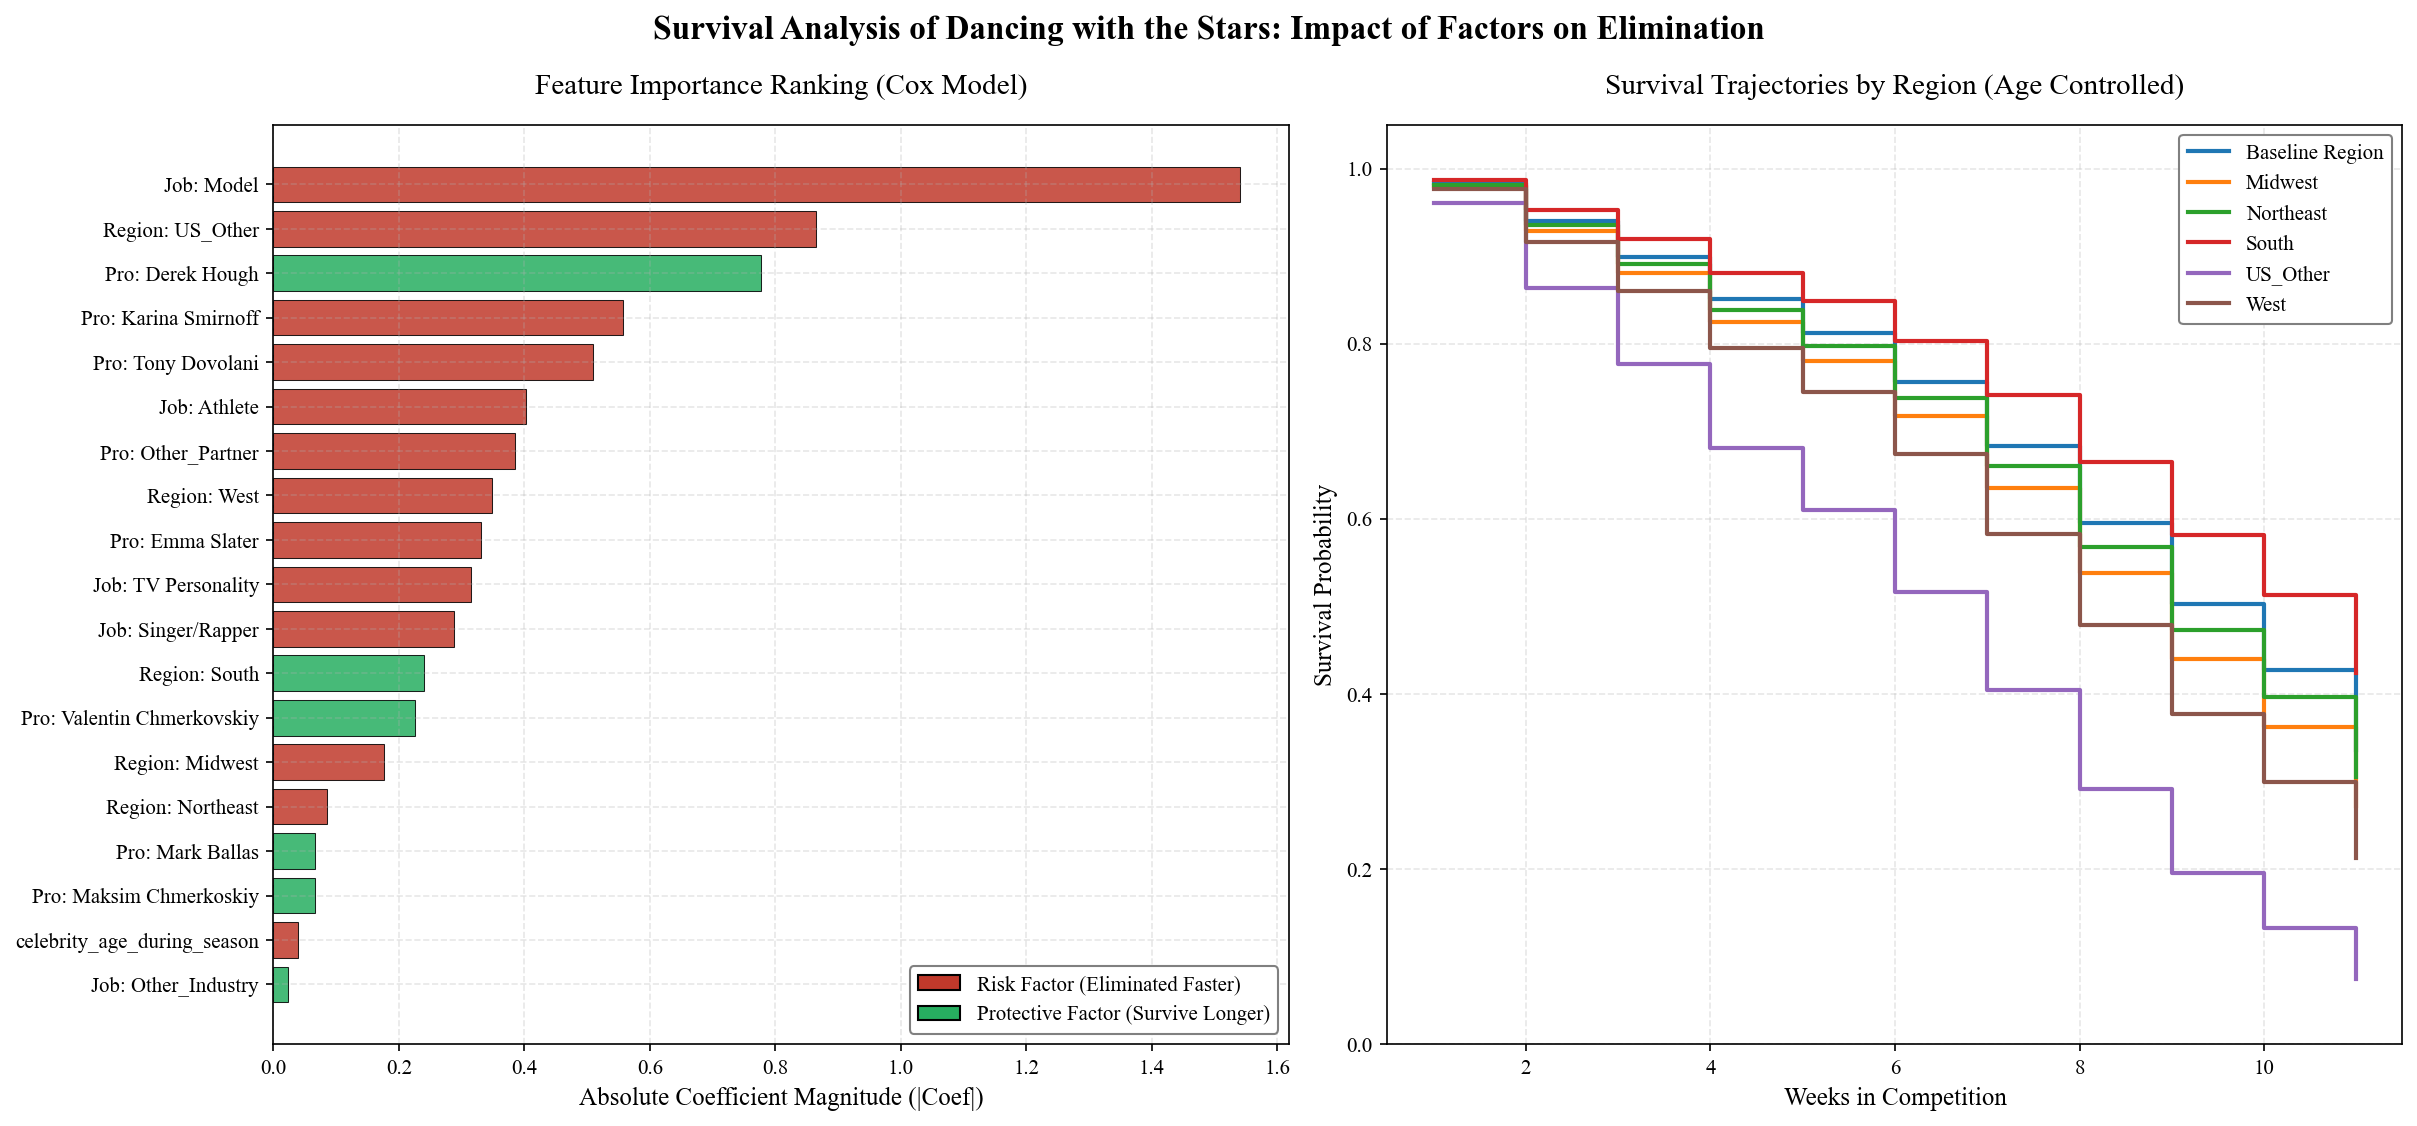

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
import re

# ==========================================
# 0. 全局绘图风格设置 (根据你提供的截图)
# ==========================================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"], # 优先Times，没有则退回DejaVu
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 150,          # 高分辨率
    "axes.grid": True,          # 显示网格
    "grid.alpha": 0.3,          # 网格透明度
    "grid.linestyle": "--",     # 网格虚线
    "axes.facecolor": "white",  # 坐标轴背景白
    "figure.facecolor": "white",# 画布背景白
    "lines.linewidth": 1.5,     # 线宽
    "pdf.fonttype": 42          # 矢量字体的兼容性
})

# ==========================================
# 1. 数据加载与预处理 (保持之前的逻辑)
# ==========================================
df = pd.read_csv('2026_MCM_Problem_C_Data.csv')

# --- 解析生存时间 (Duration) 和 事件 (Event) ---
temp_weeks = df['results'].astype(str).str.extract(r'Eliminated Week (\d+)').astype(float)
df['temp_week'] = temp_weeks
max_weeks_by_season = df.groupby('season')['temp_week'].max().to_dict()

def parse_survival(row):
    result_str = str(row['results']).lower()
    season = row['season']
    max_w = max_weeks_by_season.get(season, 10)
    
    if 'eliminated week' in result_str:
        match = re.search(r'week (\d+)', result_str)
        if match:
            return int(match.group(1)), 1 # Event=1 (淘汰)
    elif 'place' in result_str:
        return max_w, 0 # Event=0 (存活/删失)
    elif 'withdrew' in result_str:
        return max_w // 2, 0 
    return max_w, 0

df[['T', 'E']] = df.apply(parse_survival, axis=1, result_type='expand')

# --- 特征工程 ---

# 1. 地理映射 (State -> Region)
us_state_to_region = {
    'Maine': 'Northeast', 'New Hampshire': 'Northeast', 'Vermont': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New York': 'Northeast', 'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast',
    'Ohio': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest',
    'North Dakota': 'Midwest', 'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Delaware': 'South', 'Maryland': 'South', 'Virginia': 'South', 'West Virginia': 'South',
    'Kentucky': 'South', 'North Carolina': 'South', 'South Carolina': 'South', 'Tennessee': 'South',
    'Georgia': 'South', 'Florida': 'South', 'Alabama': 'South', 'Mississippi': 'South',
    'Arkansas': 'South', 'Louisiana': 'South', 'Texas': 'South', 'Oklahoma': 'South', 
    'Washington D.C.': 'South',
    'Montana': 'West', 'Idaho': 'West', 'Wyoming': 'West', 'Colorado': 'West',
    'New Mexico': 'West', 'Arizona': 'West', 'Utah': 'West', 'Nevada': 'West',
    'California': 'West', 'Oregon': 'West', 'Washington': 'West', 'Alaska': 'West', 'Hawaii': 'West'
}

def map_region(row):
    country = str(row['celebrity_homecountry/region']).strip()
    state = str(row['celebrity_homestate']).strip()
    if country != 'United States':
        return 'International'
    for key in us_state_to_region:
        if key in state:
            return us_state_to_region[key]
    return 'US_Other'

df['geo_region'] = df.apply(map_region, axis=1)

# 2. 舞伴分组 (Top 8)
top_partners = df['ballroom_partner'].value_counts().nlargest(8).index
df['partner_group'] = df['ballroom_partner'].apply(lambda x: x if x in top_partners else 'Other_Partner')

# 3. 行业分组 (Top 5)
top_industries = df['celebrity_industry'].value_counts().nlargest(5).index
df['industry_group'] = df['celebrity_industry'].apply(lambda x: x if x in top_industries else 'Other_Industry')

# ==========================================
# 2. Cox 模型拟合
# ==========================================
# 注意：年龄 (Age) 依然在模型里作为控制变量，但不单独画图
model_df = df[['T', 'E', 'celebrity_age_during_season', 'geo_region', 'partner_group', 'industry_group']].dropna()
model_df = pd.get_dummies(model_df, columns=['geo_region', 'partner_group', 'industry_group'], drop_first=True)

cph = CoxPHFitter()
cph.fit(model_df, duration_col='T', event_col='E')

# ==========================================
# 3. 定制化绘图 (1x2 布局)
# ==========================================
# 创建 1 行 2 列的布局
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# --- 图 1 (左): 特征重要性排序 (Feature Importance) ---
coeffs = cph.params_
coeffs_sorted = coeffs.abs().sort_values(ascending=True)
# 使用更符合学术风格的配色：深红(Risk) vs 深青(Protective)
colors = ['#C0392B' if coeffs[i] > 0 else '#27AE60' for i in coeffs_sorted.index]

ax1.barh(coeffs_sorted.index, coeffs_sorted.values, color=colors, alpha=0.85, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Absolute Coefficient Magnitude (|Coef|)')
ax1.set_title('Feature Importance Ranking (Cox Model)', pad=15)

# 简化标签
new_labels = [label.replace('geo_region_', 'Region: ')
                   .replace('partner_group_', 'Pro: ')
                   .replace('industry_group_', 'Job: ') 
              for label in coeffs_sorted.index]
# 新代码 (修复版本)
ax1.set_yticks(range(len(new_labels)))  # 先固定刻度位置
ax1.set_yticklabels(new_labels)         # 再设置标签文字


# 自定义图例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#C0392B', edgecolor='black', label='Risk Factor (Eliminated Faster)'),
                   Patch(facecolor='#27AE60', edgecolor='black', label='Protective Factor (Survive Longer)')]
ax1.legend(handles=legend_elements, loc='lower right', frameon=True, framealpha=1, edgecolor='gray')


# --- 图 2 (右): 地理区域生存曲线对比 (Regional Survival Curves) ---
available_regions = [col for col in model_df.columns if 'geo_region' in col]

if available_regions:
    # 构造预测数据
    covariates = pd.DataFrame(np.zeros((len(available_regions) + 1, len(model_df.columns)-2)), 
                              columns=model_df.drop(['T', 'E'], axis=1).columns)
    
    # 设定控制变量：年龄设为均值
    mean_age = model_df['celebrity_age_during_season'].mean()
    covariates.loc[0, 'celebrity_age_during_season'] = mean_age
    
    region_labels = ['Baseline Region']
    
    for i, reg in enumerate(available_regions):
        covariates.iloc[i+1, :] = 0 
        covariates.loc[i+1, 'celebrity_age_during_season'] = mean_age
        covariates.loc[i+1, reg] = 1 # 设定当前地区为1
        region_labels.append(reg.replace('geo_region_', ''))

    surv_funcs = cph.predict_survival_function(covariates)
    
    # 绘图：使用学术常用的颜色循环
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for i, col in enumerate(surv_funcs.columns):
        ax2.step(surv_funcs.index, surv_funcs[col], where="post", label=region_labels[i], linewidth=2)

    ax2.set_ylim(0, 1.05)
    ax2.set_xlabel('Weeks in Competition')
    ax2.set_ylabel('Survival Probability')
    ax2.set_title('Survival Trajectories by Region (Age Controlled)', pad=15)
    ax2.legend(frameon=True, framealpha=1, edgecolor='gray')

plt.suptitle('Survival Analysis of Dancing with the Stars: Impact of Factors on Elimination', y=1.05, fontsize=16, fontweight='bold')
plt.show()


In [20]:
# ==========================================
# 2.5 模型检验 (Model Diagnostics)
# ==========================================
print("\n=== Checking Proportional Hazards Assumption ===")
# 使用 check_assumptions 方法，它会自动计算 Schoenfeld 残差并进行卡方检验
# p_value_threshold=0.05: 如果 p < 0.05，会发出警告，说明违反了假设
cph.check_assumptions(model_df, p_value_threshold=0.05, show_plots=False)



=== Checking Proportional Hazards Assumption ===
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 421 total observations, 123 right-censored observations>
         test_name = proportional_hazard_test

---
                                          test_statistic      p  -log2(p)
celebrity_age_during_season         km              0.20   0.65      0.61
                                    rank            0.32   0.57      0.81
geo_region_Midwest                  km              0.01   0.92      0.12
                                    rank            0.01   0.93      0.10
geo_region_Northeast                km              0.10   0.75      0.42
                                    rank            0.03   0.87      0.20
geo_region_South                    km              0.76   0.38      1.39
                                    rank            0.86   0.35      1.50
geo_region_US_Other                 km              1.38   0.24      2.06
                                    rank            1.41   0.24      2.09
geo_region_West                     km              0.53   0.46      1.11
                                    rank            0.39   0.53      0.90
industry_group_Athlete              km              2.25   0.13      2.90
                                    rank            1.76   0.18      2.44
industry_group_Model                km              0.73   0.39      1.35
                                    rank            0.95   0.33      1.60
industry_group_Other_Industry       km             10.67 <0.005      9.84
                                    rank           10.48 <0.005      9.70
industry_group_Singer/Rapper        km              2.62   0.11      3.25
                                    rank            2.39   0.12      3.04
industry_group_TV Personality       km              0.36   0.55      0.86
                                    rank            0.18   0.67      0.57
partner_group_Derek Hough           km              0.67   0.41      1.27
                                    rank            0.38   0.54      0.89
partner_group_Emma Slater           km              0.92   0.34      1.56
                                    rank            0.66   0.42      1.27
partner_group_Karina Smirnoff       km              1.95   0.16      2.62
                                    rank            2.49   0.11      3.13
partner_group_Maksim Chmerkoskiy    km              0.66   0.42      1.27
                                    rank            0.74   0.39      1.36
partner_group_Mark Ballas           km              2.95   0.09      3.54
                                    rank            3.34   0.07      3.88
partner_group_Other_Partner         km              5.70   0.02      5.88
                                    rank            5.28   0.02      5.53
partner_group_Tony Dovolani         km              1.11   0.29      1.78
                                    rank            1.47   0.23      2.15
partner_group_Valentin Chmerkovskiy km              1.91   0.17      2.58
                                    rank            1.51   0.22      2.19



1. Variable 'partner_group_Other_Partner' failed the non-proportional test: p-value is 0.0170.

   Advice: with so few unique values (only 2), you can include
`strata=['partner_group_Other_Partner', ...]` in the call in `.fit`. See documentation in link [E]
below.

2. Variable 'industry_group_Other_Industry' failed the non-proportional test: p-value is 0.0011.

   Advice: with so few unique values (only 2), you can include
`strata=['industry_group_Other_Industry', ...]` in the call in `.fit`. See documentation in link [E]
below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proporti

[]

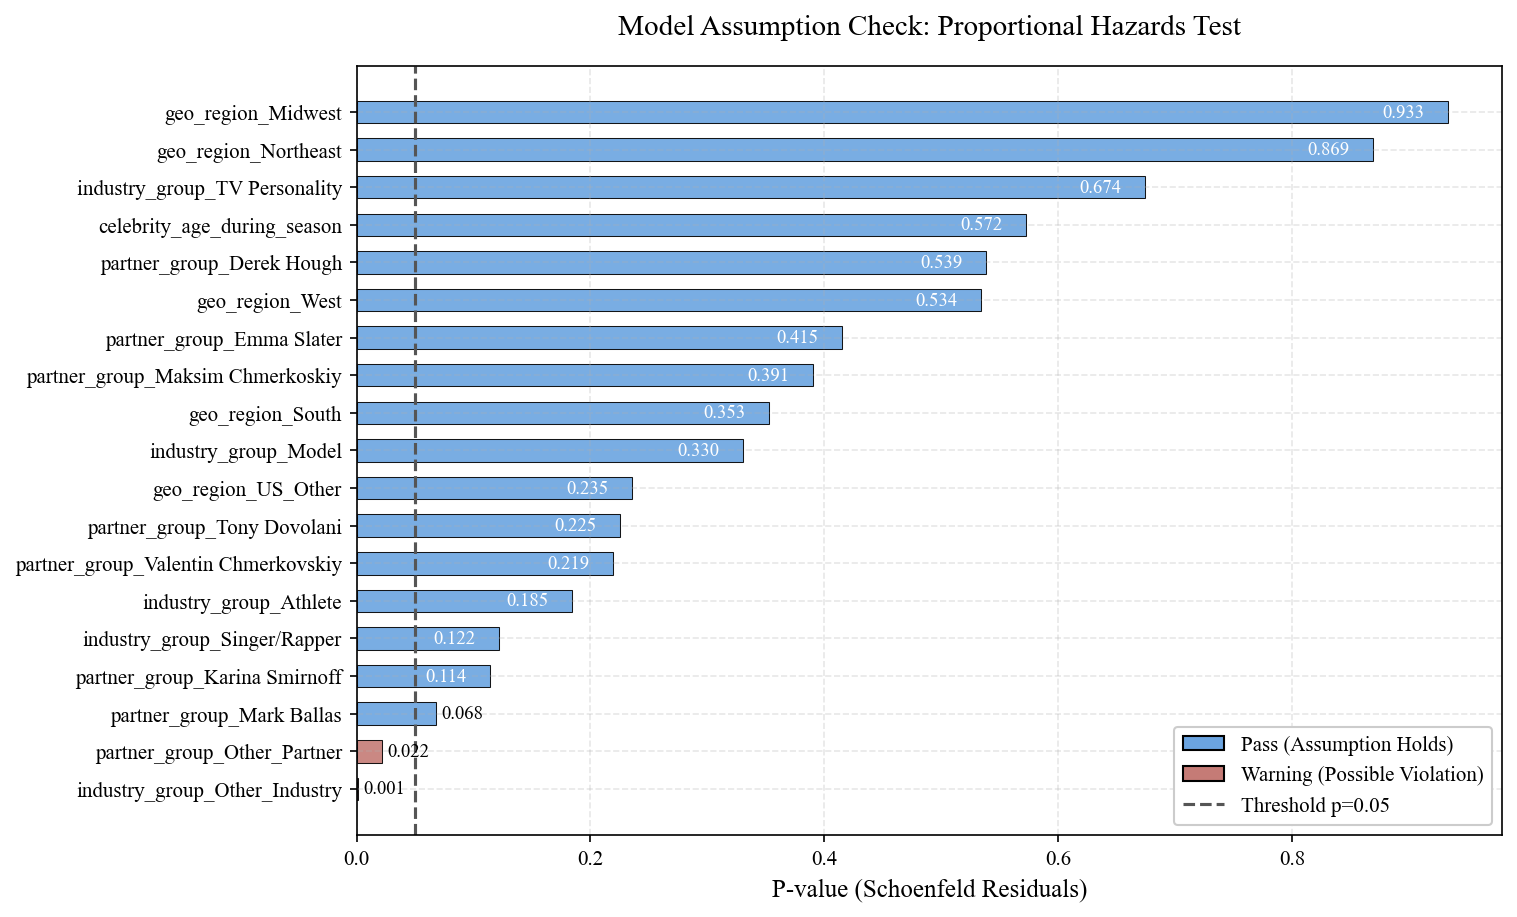

In [21]:
from lifelines.statistics import proportional_hazard_test
import matplotlib.pyplot as plt

# ==========================================
# 0. 全局风格设置 (保持不变)
# ==========================================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 150,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "lines.linewidth": 1.5,
    "pdf.fonttype": 42
})

# ==========================================
# 1. 计算检验统计量
# ==========================================
results = proportional_hazard_test(cph, model_df, time_transform='rank')
summary_df = results.summary.sort_values('p', ascending=True)

# ==========================================
# 2. 绘制低饱和度配色图表
# ==========================================
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# --- 配色方案 (低饱和度/莫兰迪色系) ---
PASS_COLOR = '#6BA4E0'
FAIL_COLOR = '#C57B76' 

# 颜色逻辑
colors = [PASS_COLOR if p >= 0.05 else FAIL_COLOR for p in summary_df['p']]

# 绘制条形图
bars = ax.barh(summary_df.index, summary_df['p'], color=colors, edgecolor='black', alpha=0.9, height=0.6, linewidth=0.5)

# 绘制阈值线 (P=0.05) - 使用深灰色虚线，比红色更柔和
ax.axvline(0.05, color='#555555', linestyle='--', linewidth=1.5, label='Threshold (p=0.05)')

# 简化Y轴标签
new_labels = [label.replace('geo_region_', 'Region: ')
                   .replace('partner_group_', 'Pro: ')
                   .replace('industry_group_', 'Job: ') 
              for label in summary_df.index]
# 新代码 (修复版本)
ax1.set_yticks(range(len(new_labels)))  # 先固定刻度位置
ax1.set_yticklabels(new_labels)         # 再设置标签文字


# 标题与标签
ax.set_xlabel('P-value (Schoenfeld Residuals)')
ax.set_title('Model Assumption Check: Proportional Hazards Test', pad=15)

# 添加数值标签
for bar in bars:
    width = bar.get_width()
    # 智能调整位置
    x_pos = width + 0.005 if width < 0.1 else width - 0.02
    ha = 'left' if width < 0.1 else 'right'
    color = 'black' if width < 0.1 else 'white'
    
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
            va='center', ha=ha, color=color, fontsize=9)

# 自定义图例 (匹配新颜色)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PASS_COLOR, edgecolor='black', label='Pass (Assumption Holds)'),
    Patch(facecolor=FAIL_COLOR, edgecolor='black', label='Warning (Possible Violation)'),
    plt.Line2D([0], [0], color='#555555', linestyle='--', label='Threshold p=0.05')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, framealpha=1, edgecolor='#CCCCCC')

plt.show()
